In [1]:
import csv
import json

import numpy as np
import pandas as pd
from datasets import load_dataset

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc

from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding, AutoTokenizer, AutoModelForSequenceClassification

import torch

# from tqdm import tqdm
# import os
# import evaluate
# from datasets import load_dataset
# from collections import Counter, defaultdict

# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


d:\Miniconda\envs\hugging\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from nltk import sent_tokenize
import nltk
nltk.download('punkt')
with open("all.jsonl", 'r') as jsonl_file:
    jsonl_data = jsonl_file.read()
    json_lines = [
        json_line for json_line in jsonl_data.splitlines() if json_line.strip()]
    jsons_objs = [json.loads(json_line) for json_line in json_lines]
    jsons_objs_expand = []
    for i, obj in enumerate(jsons_objs):
        word_cnt = []
        for human_answer in obj['human_answers']:
            sentences = sent_tokenize(human_answer)
            # split the response into 3 sentences
            grouped_sentences = [" ".join(sentences[i:i + 3]) for i in range(0, len(sentences), 3)]
            for sent in grouped_sentences:
                jsons_objs_expand.append(
                    {'question_id': i, 'text': sent, 'label': 0})
        for chatgpt_answer in obj['chatgpt_answers']:
            sentences = sent_tokenize(chatgpt_answer)
            grouped_sentences = [" ".join(sentences[i:i + 3]) for i in range(0, len(sentences), 3)]
            for sent in grouped_sentences:
                jsons_objs_expand.append(
                    {'question_id': i, 'text': sent, 'label': 1})

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cyarq\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
with open("all_sent.csv", "w") as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow([key for key in jsons_objs_expand[0].keys()])
    writer.writerows([json_obj.values() for json_obj in jsons_objs_expand])

In [4]:
with open('id_to_question.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['id', 'question'])
    for i, obj in enumerate(jsons_objs):
        writer.writerow([i, obj['question']])

In [5]:
all_df = pd.read_csv("all_sent.csv")
all_df.dropna(inplace=True)
all_df.head()

,question_id,text,label
0,0,"Basically there are many categories of "" Best ...",0
1,0,"Same thing for best sellers . Also , IIRC the ...",0
2,0,I guess even if you do n't stay there for long...,0
3,0,"If you 're hearing about it , it 's because it...",0
4,0,"One reason is lots of catagories . However , h...",0


In [7]:
all_df['length'] = all_df['text'].apply(lambda x: len(x.split()))
all_df['length'].groupby(all_df['label']).describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,147274.0,53.218110,27.988068,1.0,34.0,51.0,69.0,457.0
1,72342.0,64.366841,30.838738,1.0,46.0,62.0,78.0,379.0


(array([3.620e+02, 1.904e+03, 3.121e+03, 3.853e+03, 3.637e+03, 6.084e+03,
        7.270e+03, 9.793e+03, 9.707e+03, 6.952e+03, 5.823e+03, 3.558e+03,
        2.698e+03, 1.723e+03, 1.499e+03, 9.120e+02, 8.530e+02, 6.490e+02,
        4.000e+02, 3.930e+02, 2.490e+02, 2.080e+02, 1.280e+02, 1.410e+02,
        9.400e+01, 8.500e+01, 5.200e+01, 4.600e+01, 3.900e+01, 2.300e+01,
        2.500e+01, 1.600e+01, 9.000e+00, 7.000e+00, 6.000e+00, 4.000e+00,
        8.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  1.  ,   8.56,  16.12,  23.68,  31.24,  38.8 ,  46.36,  53.92,
         61.48,  69.04,  76.6 ,  84.16,  91.72,  99.28, 106.84, 114.4 ,
        121.96, 129.52, 137.08, 144.64, 152.2 , 159.76, 167.32, 174.88,
        182.44, 190.  , 197.56, 205.12, 212.68, 220.24, 227.8 , 235.36,
        242.92, 250.48, 258.04, 265.6 , 273.16, 280.72, 288.28, 295.84,
        303.4 , 

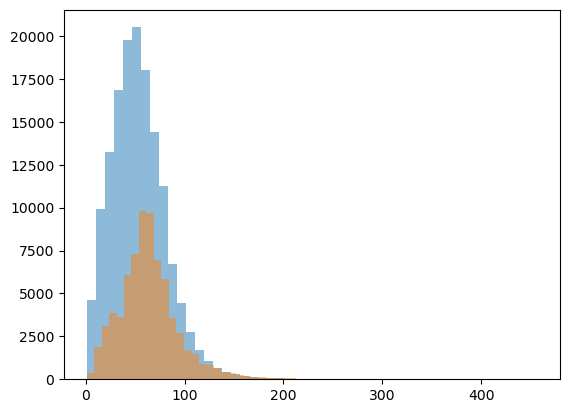

In [8]:
import matplotlib.pyplot as plt

plt.hist(all_df[all_df['label'] == 0]['length'], bins=50, alpha=0.5, label='human')
plt.hist(all_df[all_df['label'] == 1]['length'], bins=50, alpha=0.5, label='chatgpt')

In [9]:

train_df, dev_df = train_test_split(all_df, test_size=0.2, random_state=42)
train_df.shape, dev_df.shape

((175692, 4), (43924, 4))

### Data Augumentation

In [10]:
with open("all_train_sent.csv", "w") as csv_file:
    csv_file.write(train_df.to_csv(index=False))
with open("all_dev_sent.csv", "w") as csv_file:
    csv_file.write(dev_df.to_csv(index=False))

In [11]:
all_dataset = load_dataset('csv', data_files={'train': 'all_train_sent.csv', 'dev': 'all_dev_sent.csv'})
all_dataset = all_dataset.remove_columns(["question_id"])
all_dataset

Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 399.97it/s]
Generating train split: 0 examples [00:00, ? examples/s]d:\Miniconda\envs\hugging\lib\site-packages\datasets\download\streaming_download_manager.py:776: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)
Generating dev split: 0 examples [00:00, ? examples/s]               d:\Miniconda\envs\hugging\lib\site-packages\datasets\download\streaming_download_manager.py:776: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  return pd.read_csv(xopen(filepath_or_buffer, "rb", use_auth_token=use_auth_token), **kwargs)


Dataset csv downloaded and prepared to C:/Users/cyarq/.cache/huggingface/datasets/csv/default-ce0cbae5942c0a29/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 111.09it/s]


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'length'],
        num_rows: 175692
    })
    dev: Dataset({
        features: ['text', 'label', 'length'],
        num_rows: 43924
    })
})

# Dummy classifiers

In [12]:
mf_dummy_clf = DummyClassifier(strategy="most_frequent")
mf_dummy_clf.fit(train_df.text, train_df.label)
mf_dummy_test_preds = mf_dummy_clf.predict(dev_df.text)
precision_recall_fscore_support(dev_df.label, mf_dummy_test_preds, average='binary')

d:\Miniconda\envs\hugging\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.0, 0.0, 0.0, None)

In [13]:
random_dummy_clf = DummyClassifier(strategy="stratified")
random_dummy_clf.fit(train_df.text, train_df.label)
random_dummy_test_preds = random_dummy_clf.predict(dev_df.text)
precision_recall_fscore_support(dev_df.label, random_dummy_test_preds, average='binary')

(0.3314356265861856, 0.3328970031002411, 0.3321647074998281, None)

In [15]:
fpr_2, tpr_2, threshold = roc_curve(np.array(dev_df.label), random_dummy_test_preds)
auc(fpr_2, tpr_2)

0.5007339243798665

# Standard sklearn classifier(s)

In [16]:
# Convert text to features using a simple tf-idf
# min_df = is the minimum occurrences for a word to a feature
vectorizer = TfidfVectorizer(min_df=10)
X_train = vectorizer.fit_transform(train_df.text.values.astype('U'))

# Train a Logisitic Regression classifier
clf = LogisticRegression()
clf.fit(X_train, train_df.label)

# Test the classifier by converting test data to features
X_test = vectorizer.transform(dev_df.text.values.astype('U'))
y_pred = clf.predict(X_test)
y_true = dev_df.label

# We'll using binary F1 to test whether we can detect sarcastic comments
precision_recall_fscore_support(y_true, y_pred, average='binary')


d:\Miniconda\envs\hugging\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.9077967586508979, 0.8566999655528763, 0.8815085244390883, None)

In [17]:
pred_df = pd.DataFrame({'text': dev_df.text, 'label': dev_df.label, 'predict': y_pred})
pd.set_option('display.max_colwidth', None)
not_match_df = pred_df[pred_df.label != pred_df.predict]
not_match_df

,text,label,predict
154826,"so you have a cup on one end of a string . and on the other end of the string is your friend with a cup(You two are the computers , the cups are the modems ) . you want to send a message to your friend(this is like when you go to click the start game button in one of your disney junior games ) .",0,1
58296,"\nSure! The two trees that are joined by a branch are called ""co-dominant"" trees. This means that both trees are growing together and supporting each other.",1,0
181679,"The Big Ten Conference is a collegiate athletic conference that includes 14 member institutions in the United States. The conference is divided into two divisions, the East Division and the West Division. The 14 member institutions of the Big Ten Conference are:\n\nEast Division:\n\nUniversity of Illinois at Urbana–Champaign\nIndiana University\nUniversity of Maryland\nMichigan State University\nOhio State University\nPenn State University\nRutgers University\nWest Division:\n\nUniversity of Iowa\nUniversity of Minnesota\nUniversity of Nebraska\nNorthwestern University\nPurdue University\nUniversity of Wisconsin\nUniversity of Michigan\nSo, there are 14 schools in the Big Ten Conference.",1,0
127620,"Moving a file is as simple as changing the catalog reference . If you are referring to a move that requires creating a new copy of the file and a copy that copies to a different location then this is faster because there are bottlenecks associated with different modes of transfer , such as USB bandwidth limits and controller latency ( or internet bandwidth limits ) .",0,1
149032,"Now, let's say you add some salt to the water. According to Le Chatelier's principle, the salt will make it harder for the water molecules to escape into the air as steam. This is because the salt takes up space in the water, and there's less room for the water molecules to move around.",1,0
...,...,...,...
208016,"However, it's not accurate to say that the price of Apple's stock has consistently gained significantly overnight over the past 10 years.",1,0
131075,"Viruses do not have the ability to reproduce on their own, but they can replicate inside the cells of other living organisms. Because viruses do not have all of these characteristics, they are not considered living organisms. Instead, they are classified as non-living particles that are capable of infecting and replicating inside the cells of other living organisms.",1,0
106895,"These are intersections with cameras pointing each direction . The cameras sense cars coming and send a signal to the lights to change . It allows the lights to best serve the traffic in a dynamic way , ie adjust to unpredictable patterns in the traffic .",0,1
151349,"Here's how it works:\r\n\r\nImagine that you have three pipes, each with water flowing through it. If you turn on a tap at one end of one of the pipes, the water will start flowing through that pipe. But if you turn on two taps at the same time, the water will flow faster and stronger.",1,0


In [18]:
fpr_3, tpr_3, threshold = roc_curve(np.array(y_true), y_pred)
auc(fpr_3, tpr_3)

0.9068769643127024

# Fancy Huggingface classifiers

We'll use [MiniLM](https://huggingface.co/microsoft/MiniLM-L12-H384-uncased) which is a compressed version of a BERT-like model that is faster to train

In [19]:
torch.cuda.is_available()

True

In [20]:
# Verify there's at least one GPU sitting around (or not if you want to try CPU!)
torch.cuda.device_count()

1

In [21]:
all_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'length'],
        num_rows: 175692
    })
    dev: Dataset({
        features: ['text', 'label', 'length'],
        num_rows: 43924
    })
})

### Prepare the text

We need to tokenize the data. Each large language model (LLM) has its own tokenizer, so we will have to specify how the model expects the text to be turned into tokens. In huggingface, we'll specify a LLM using a string name, e.g., "microsoft/MiniLM-L12-H384-uncased" for MiniLM. You can see more details on different possible model on Huggingface's [model repo](https://huggingface.co/models)

In [22]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/MiniLM-L12-H384-uncased")
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=512)

tokenized_all = all_dataset.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### Train the model

In [ ]:
# Huggingface will generate model checkpoints and these can
# take up a lot of space, so be sure to set this directory somewhere where
# you can check

output_dir = '.'

# This code block is used so we can have a deterministic training procedure
# (i.e., get the same result each time)
model_name = "microsoft/MiniLM-L12-H384-uncased"


def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)


training_args = TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    learning_rate=8e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    do_eval=True,
    seed=1234,
    save_strategy='epoch',
    evaluation_strategy='epoch',
    logging_dir=output_dir + 'logs/',
    label_smoothing_factor=0.1,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_all["train"],
    eval_dataset=tokenized_all["dev"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()


In [26]:
trainer.evaluate()

{'eval_loss': 0.21020738780498505,
 'eval_runtime': 48.0067,
 'eval_samples_per_second': 355.93,
 'eval_steps_per_second': 44.494,
 'epoch': 1.0}

In [27]:
dev_logits = trainer.predict(tokenized_all["dev"])
print(dev_logits.predictions.shape, dev_logits.label_ids.shape)
dev_preds = np.argmax(dev_logits.predictions, axis=-1)
precision_recall_fscore_support(dev_df.label, dev_preds, average='binary')

(17087, 2) (17087,)


(0.9847696879643388, 0.9994344957587182, 0.9920478997099823, None)

In [28]:
tokenized_aug = aug_dataset.map(preprocess_function, batched=True)

aug_dev_logits = trainer.predict(tokenized_aug["train"])
print(aug_dev_logits.predictions.shape, aug_dev_logits.label_ids.shape)
aug_dev_preds = np.argmax(aug_dev_logits.predictions, axis=-1)
fpr_aug, tpr_aug, threshold = roc_curve(np.array(aug_dev_df.label), aug_dev_preds)
auc(fpr_aug, tpr_aug)

Map:   0%|          | 0/17087 [00:00<?, ? examples/s]

(17087, 2) (17087,)


0.5295804107641314

In [29]:
fpr, tpr, threshold = roc_curve(np.array(dev_df.label), dev_preds)
auc(fpr, tpr)

0.9962373633096766

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

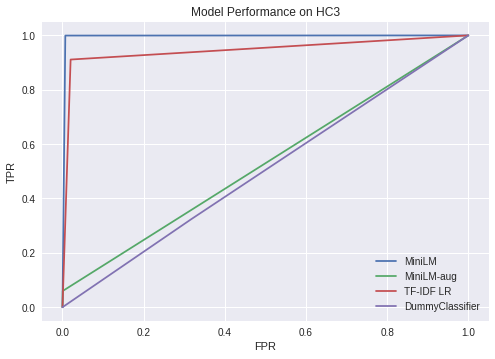

In [32]:
plt.style.use("seaborn")
plt.plot(fpr, tpr)
plt.plot(fpr_aug, tpr_aug)
plt.plot(fpr_3, tpr_3)
plt.plot(fpr_2, tpr_2)
plt.legend(['MiniLM', 'MiniLM-aug', 'TF-IDF LR', 'DummyClassifier'])
plt.title("Model Performance on HC3")
plt.xlabel("FPR")
plt.ylabel("TPR")
# plt.xscale('log')
# plt.yscale('log')
plt.savefig("res")